# Practical 1: Predicting Efficiency of Organic Solar Cell

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# (1) Read in Data Files

##Read in Original Feature File
The goal is to obtain the target values (column: 'gap')

In [3]:
%%time
df_trainOR = pd.read_csv("train.csv")

CPU times: user 38.7 s, sys: 6.29 s, total: 45 s
Wall time: 46.1 s


In [4]:
Y_train = df_trainOR['gap']
del df_trainOR

## Read in Feature Files created by SM and WF

In [6]:
%%time
df_trainSM =pd.read_csv("df_train_withSMFeatures.csv")
df_trainWF=pd.read_csv("train_rdkit.csv")

CPU times: user 1min 6s, sys: 8.23 s, total: 1min 14s
Wall time: 1min 16s


In [ ]:
df_trainSM.drop(["Unnamed: 0", "smiles"], axis=1,inplace=True)
df_trainWF.drop(["smiles"], axis=1,inplace=True)

In [ ]:
%%time
df_train=pd.concat([df_trainSM,df_trainWF], axis=1)

In [ ]:
print df_trainSM.shape[1]+df_trainWF.shape[1], df_train.shape[1]

In [ ]:
df_train.head()

In [ ]:
colList = df_train.columns.tolist()

for col in colList:
    df_train[col] = df_train[col].astype('float64')

In [ ]:
a = df_train.dtypes.values
counter=0
for i in a:
    if i == np.dtype('float64'):
        counter+=1
print 'Total Number of Columns: ', len(colList)
print 'Total Number of Columns as Float64:', counter

As seen above, we have some values with 'NaN'. We will replace these values with '0' as shown below.

In [ ]:
df_train.fillna(value=0, inplace=True)
df_train.head()

In [ ]:
#To show the location of infinite values
df_trainWF.describe()

We also noticed some columns with 'inf' values which will be replaced by the 'max value recognized by float'

In [ ]:
#1) Replace INF with MAX FLOAT VALUE
#---------------------------------------------
#max_floatVal = np.finfo(np.float64).max
#adjusted_maxFloatVal = max_floatVal/(10**10)
#print adjusted_maxFloatVal
#df_train = df_train.replace([np.inf, -np.inf], adjusted_maxFloatVal)

#2) Replace INF with 0
#---------------------------------------------
#df_train = df_train.replace([np.inf, -np.inf], 0)

#3) DROP COLUMN with INF
#--------------------------------------------
df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

In [ ]:
df_train.shape

In [ ]:
df_train.describe()

In [ ]:
#Reality Checks: 
#print 'Has the max value of a column with "inf" been replaced by a large value?: ', max(df_train.MaxEStateIndex)
print 'What are the total number of "NaN" occurences?: ', (np.isnan(df_train).sum()).sum()
print 'What are the total number of "inf" occurences?: ', (np.isinf(df_train).sum()).sum()

In [16]:
%%time
#Nan values are replaced by 0, Infinity columns are dropped, 
df_train.to_csv('df_train_SM_and_WF_v1.csv')

Wall time: 3min 25s


In [7]:
df_train =pd.read_csv("df_train_SM_and_WF_v1.csv")

In [17]:
#alternate df_train2
df_train2=pd.concat([df_trainSM,df_trainWF], axis=1)

#Convert alternate df_train2 columns to float
colList = df_train2.columns.tolist()
for col in colList:
    df_train2[col] = df_train2[col].astype('float64')

#3) DROP COLUMNs with NAN and INF
#--------------------------------------------
df_train2 = df_train2.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

print df_train2.shape

(1000000, 373)


In [ ]:
%%time
#Nan and Infinity columns are dropped, 
df_train2.to_csv('df_train2_SM_and_WF_v1.csv')

In [17]:
del df_trainSM, df_trainWF

#(2) Regression (Non-PCA)

## Split into train-validate set

In [8]:
#Train and Val set on df_train
train_X, val_X, train_Y, val_Y = train_test_split(df_train, Y_train, train_size=0.7)

##Linear Regression

In [9]:
%%time
LR = LinearRegression()
LR.fit(train_X, train_Y)

CPU times: user 44.5 s, sys: 7.92 s, total: 52.4 s
Wall time: 29.6 s


In [28]:
## Root mean-squared error: 
LR_err=(LR.predict(val_X)-val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(LR_err)

Root Mean Squared Error is:  516266    0.470546
260717    0.406900
409484    0.374202
994725    0.161148
546899         NaN
624817         NaN
883915         NaN
809886    0.354689
581368    0.381316
513005    0.227393
619547         NaN
971679         NaN
421331         NaN
261077    0.232341
835407         NaN
89632     0.257377
372411    0.287495
715258    0.104198
893842    0.437557
834422         NaN
288689         NaN
30580          NaN
845467    0.506876
359705         NaN
405       0.489172
317653         NaN
324301    0.550360
523882         NaN
195259         NaN
114796         NaN
            ...   
978683         NaN
370327         NaN
247795    0.521973
7603      0.327244
245321    0.052387
56556          NaN
794711    0.114550
903532    0.220998
954512         NaN
964683         NaN
790506    0.379696
942309         NaN
346577         NaN
688734    0.473835
797569    0.368703
546431    0.537963
233199         NaN
573596         NaN
354290    0.200810
699038    0.161580
94

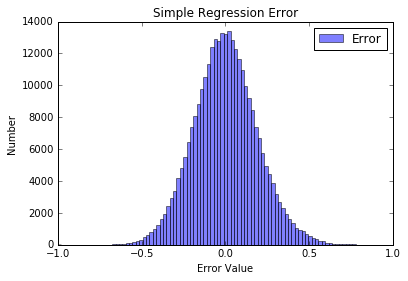

In [31]:
bins = np.linspace(-1.0, 1.0, 100)

plt.hist(LR_err.tolist(), bins, alpha=0.5, label='Error')
#pyplot.hist(y, bins, alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.title("Simple Regression Error")
plt.xlabel("Error Value")
plt.ylabel("Number") 
plt.show()

In [ ]:
%%time

#-----------Model Inputs-------------------
clf_lasso = Lasso()
#parameters = {"alpha": [1e-3, 1e-1, 1.0, 5, 10, 50, 100]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 0.5, 1.0, 5, 10]}
score_func = "mean_absolute_error"
#------------------------------------------
fitmodel = cv_optimize(clf_lasso, train_X, train_Y, parameters, n_folds=10, score_func=score_func)

## Ridge Regression

In [32]:
def cv_optimize(clf, X, y, parameters, n_folds=5, score_func="mean_squared_error"):
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring= score_func)
    gs.fit(X, y)
    return gs

In [33]:
%%time

#-----------Model Inputs-------------------
clf = Ridge()
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 1.0, 10, 100]}
score_func = "mean_squared_error"
#------------------------------------------

fitmodel = cv_optimize(clf, train_X, train_Y, parameters, n_folds=10, score_func=score_func)

CPU times: user 17min 38s, sys: 5min 38s, total: 23min 16s
Wall time: 13min 48s


In [43]:
%%time
#Fit with best alpha
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Ridge(alpha=alphawechoose).fit(train_X,train_Y)

#Calculate error
pred_Ridge = clf.predict(val_X)
err=mean_squared_error(pred_Ridge, val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Best alpha:  0.0001
Root Mean Squared Error is:  0.190701299557
CPU times: user 17.7 s, sys: 7.66 s, total: 25.3 s
Wall time: 15.7 s


In [44]:
RLR_err=(pred_Ridge-val_Y)

## Plot the error distribution of Ridge Regression

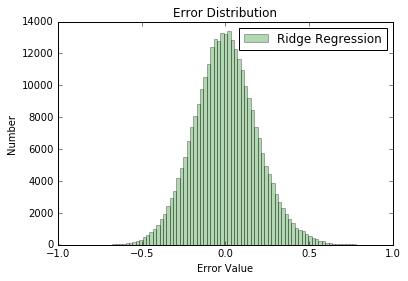

In [53]:
bins = np.linspace(-1.0, 1.0, 100)

#plt.hist(LR_err.tolist(), bins, alpha=0.3, label='Simple Regression',color="blue")
plt.hist(RLR_err.tolist(), bins, alpha=0.3, label='Ridge Regression',color="green")
plt.legend(loc='upper right')
plt.title("Error Distribution")
plt.xlabel("Error Value")
plt.ylabel("Number") 
plt.show()

In [46]:
RLR_err.tolist()

[0.2214084709169537,
 0.16558591583157822,
 0.14003298702977407,
 0.0259140282367607,
 -0.057284490165287361,
 -0.0028922021710835466,
 -0.45605510709445785,
 0.12581470835518971,
 0.14542043606588084,
 0.051674957452314985,
 -0.18201476272885664,
 -0.23749054869320618,
 -0.0011575086824171521,
 0.053972175676615386,
 -0.04568926842677179,
 0.066246602793722964,
 0.082639543311949115,
 0.010842466247356963,
 0.19146218997391862,
 -0.13511392568968628,
 -0.01491524589027815,
 -0.058529735483607848,
 0.25692277590437795,
 -0.065823986429748516,
 0.23926885158270839,
 -0.10962139630329593,
 0.30288547278408862,
 -0.15577016417257949,
 -0.16140023685894667,
 -0.3075630510316234,
 -0.30462386797204566,
 -0.19750761194172295,
 -0.070779602331118241,
 -0.071526912067849224,
 -0.077277818381403574,
 0.10231251439984135,
 -0.044954969175522663,
 -0.16156148776765855,
 -0.11257641039000754,
 0.17301923831465738,
 0.26083369745686502,
 0.20660628442634099,
 -0.014346627089766528,
 -0.039337475209

##Simple Random Forest

In [47]:
%%time
RF = RandomForestRegressor()
RF.fit(train_X, train_Y)

#Calculate error

err_RF=mean_squared_error(RF.predict(val_X), val_Y)
print 'Root Mean Squared Error is: ', np.sqrt(err_RF)

Root Mean Squared Error is:  0.100989182919
CPU times: user 8min 59s, sys: 9.98 s, total: 9min 8s
Wall time: 9min 13s


In [48]:
RF_err=RF.predict(val_X)-val_Y

## Plot the Error distribution between Ridge Regression and Random Forest

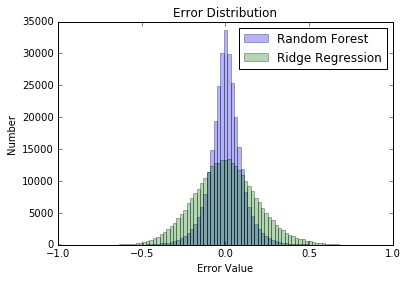

In [51]:
bins = np.linspace(-1.0, 1.0, 100)

plt.hist(RF_err.tolist(), bins, alpha=0.3, label='Random Forest',color="blue")
plt.hist(RLR_err.tolist(), bins, alpha=0.3, label='Ridge Regression',color="green")
plt.legend(loc='upper right')
plt.title("Error Distribution")
plt.xlabel("Error Value")
plt.ylabel("Number") 
plt.show()

# Random Forest with Adaboost

In [78]:
RF_compare={}
trees = range(1,21,5)    
for tree in trees:
    clfForest1_ct = RandomForestRegressor(n_estimators=tree)
    clfForest1_ct.fit(train_X, train_Y)
    ypred= clfForest1_ct.predict(val_X)
    err = mean_squared_error(ypred, val_Y)
    rmse_lat = np.sqrt(err)
    RF_compare[tree]=rmse_lat

In [79]:
RF_compare

{1: 0.15114331275681847,
 6: 0.10391598157134735,
 11: 0.098483121093483769,
 16: 0.097186591553408433}

# (3) Regression with PCA

In [19]:
%%time
pca = PCA(n_components=50, whiten=True).fit(df_train)
print "Explain variance for each PC is %s"%pca.explained_variance_ratio_
print "Total variance explained is %s"%pca.explained_variance_ratio_.sum()       
df_train_pca = pca.transform(df_train)

Explain variance for each PC is [  1.00000000e+00   6.07041180e-11   1.57651339e-11   3.19811881e-12
   1.58442244e-12   7.60886749e-13   4.27113648e-13   3.22842483e-13
   2.43411729e-13   2.02768417e-13   1.78552717e-13   1.39410346e-13
   1.18083399e-13   1.03391214e-13   8.75945004e-14   8.20808207e-14
   6.07884497e-14   5.38143854e-14   4.25506075e-14   3.27174572e-14
   2.12987474e-14   1.65323088e-14   1.24807298e-14   9.89940545e-15
   9.05395387e-15   8.15232130e-15   7.08479511e-15   6.28996576e-15
   5.65649169e-15   3.57051374e-15   2.89767086e-15   2.44143810e-15
   1.46651190e-15   1.25765245e-15   1.06265711e-15   1.00471009e-15
   8.54402112e-16   7.42802515e-16   5.92197520e-16   3.89889114e-16
   2.67335861e-16   2.30706281e-16   2.03804804e-16   1.80456827e-16
   1.72014610e-16   1.62834684e-16   1.48980160e-16   1.44799970e-16
   1.42162531e-16   1.23592838e-16]
Total variance explained is 1.0


## Split into train-validate set

In [26]:
#Train and Val set on the pca set: df_train_pca
train_X_pca, val_X_pca, train_Y_pca, val_Y_pca = train_test_split(df_train_pca, Y_train, train_size=0.7)

## Linear Regression

In [27]:
%%time
LR = LinearRegression()
LR.fit(train_X_pca, train_Y_pca)

Wall time: 2.34 s


In [28]:
## Root mean-squared error: 

RMSE_LR = np.sqrt(np.mean((LR.predict(val_X_pca)-val_Y_pca)**2))

err=mean_squared_error(LR.predict(val_X_pca), val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.207759764238


## Ridge Regression

In [29]:
%%time

#-----------Model Inputs-------------------
clf = Ridge()
#parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 1.0, 10, 100]}
score_func = "mean_squared_error"
#------------------------------------------

fitmodel = cv_optimize(clf, train_X_pca, train_Y_pca, parameters, n_folds=10, score_func=score_func)

Wall time: 40.9 s


In [30]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, solver='auto', tol=0.001),
 {'alpha': 10},
 -0.042971648218448413,
 [mean: -0.04297, std: 0.00016, params: {'alpha': 0.0001},
  mean: -0.04297, std: 0.00016, params: {'alpha': 0.001},
  mean: -0.04297, std: 0.00016, params: {'alpha': 0.1},
  mean: -0.04297, std: 0.00016, params: {'alpha': 1.0},
  mean: -0.04297, std: 0.00016, params: {'alpha': 10},
  mean: -0.04297, std: 0.00016, params: {'alpha': 100}])

In [31]:
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Ridge(alpha=alphawechoose).fit(train_X_pca, train_Y_pca)

Best alpha:  10


In [33]:
pred = clf.predict(val_X_pca)
err=mean_squared_error(pred, val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.207759764609


# Lasso Regression

In [34]:
%%time

#-----------Model Inputs-------------------
clf = Lasso()
#parameters = {"alpha": [1e-3, 1e-1, 1.0, 5, 10, 50, 100]}
parameters = {"alpha": [1e-4, 1e-3, 1e-1, 0.5, 1.0, 5, 10]}
score_func = "mean_absolute_error"
#------------------------------------------
fitmodel = cv_optimize(clf, train_X_pca, train_Y_pca, parameters, n_folds=10, score_func=score_func)

Wall time: 1min 45s


In [35]:
alphawechoose = fitmodel.best_params_['alpha']
print 'Best alpha: ', alphawechoose
clf = Lasso(alpha=alphawechoose).fit(train_X_pca,train_Y_pca)

Best alpha:  0.0001


In [52]:
lasso_pred = clf.predict(val_X_pca)
err=mean_squared_error(lasso_pred, val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

NameError: name 'val_X_pca' is not defined

# Random Forest

In [39]:
RF = RandomForestRegressor()
RF.fit(train_X_pca, train_Y_pca)

#Calculate error
err=mean_squared_error(RF.predict(val_X_pca), val_Y_pca)
print 'Root Mean Squared Error is: ', np.sqrt(err)

Root Mean Squared Error is:  0.146212927574


# Adaboost

#Create Predictions on TEST data

In [25]:
df_testWF = pd.read_csv('test_rdkit.csv')

In [26]:
df_testSM = pd.read_csv('df_test_withSMFeatures.csv')

In [30]:
df_testSM.drop(["Unnamed: 0", "smiles"], axis=1,inplace=True)
df_testWF.drop(["smiles"], axis=1,inplace=True)

In [58]:
df_train.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,160.165038,0.000000,0.000000,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,6,4.417151,69.585094,0,13.731058,0,0.000000,0,53.112196,0,31.649068,0.000000,0,0,34.401759,28.234619,0.000000,0,0.000000,57.529347,0,52.328843,0,51.81,0,5.133462,0,0,0,0,0,0,16.133663,32.649541,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,9.967957,0.000000,0.00000,0.000000,35.325943,45.323790,28.552360,30.249831,6,0.000000,68.949014,0,9.967957,0,6.420822,0,64.082088,0,0.000000,15.624026,0,0,0.000000,29.007159,0.000000,0,17.678201,42.387409,0,44.723087,0,25.78,0,-0.611785,0,0,0,0,0,0,0.000000,46.667340,0,0,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0,0,0.000000,0.000000,0.000000,8.74708,11.336786,36.417508,44.753830,27.214679,21.247788,7,0.000000,70.970372,0,13.731058,0,6.420822,0,52.914821,0,21.697978,10.373451,0,0,23.064973,23.250659,6.420822,0,11.126903,41.787918,0,49.710325,0,41.57,0,2.651992,0,0,0,0,0,0,9.468067,38.491053,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5.760247,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,40.996278,49.697689,22.887198,30.996293,7,4.417151,52.739304,0,4.983979,0,6.420822,0,68.596501,0,22.581078,20.874600,0,0,0.000000,24.023181,6.420822,0,11.126903,41.012149,0,56.281180,0,28.93,0,-0.473941,0,0,0,0,0,0,5.781605,44.081225,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11.407425,0,0,0.000000,4.983979,14.951936,8.74708,0.000000,6.066367,12.132734,27.741740,35.204189,7,8.834302,66.375451,0,28.682994,0,0.000000,0,49.576911,0,11.387856,0.000000,0,0,11.728187,28.682994,0.000000,0,0.000000,58.411213,0,66.035119,0,103.62,0,1.147669,0,0,0,0,0,0,20.986598,40.699067,0,0,0,0


In [56]:
df_test=pd.concat([df_testSM,df_testWF], axis=1)

In [59]:
df_test.head()

,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,feat_010,feat_011,feat_012,feat_013,feat_014,feat_015,feat_016,feat_017,feat_018,feat_019,feat_020,feat_021,feat_022,feat_023,feat_024,feat_025,feat_026,feat_027,feat_028,feat_029,feat_030,feat_031,feat_032,feat_033,feat_034,feat_035,feat_036,feat_037,feat_038,feat_039,feat_040,feat_041,feat_042,feat_043,feat_044,feat_045,feat_046,feat_047,feat_048,feat_049,feat_050,...,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,collections,descList,rdPartialCharges
0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,9.967957,0,8.74708,11.336786,6.066367,30.331835,61.342313,28.278289,7,0.000000,77.579598,0,23.699016,0,0.000000,0,60.368796,0,10.440599,0.0000,0,0,23.064973,23.699016,0,0,0.000000,60.368796,0,64.955223,0,67.35,0,2.978831,0,0,0,0,0,0,9.241820,45.946015,NaN,NaN,NaN,NaN
1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,0.000000,0,8.74708,22.673572,0.000000,29.645531,16.969292,42.732504,6,0.000000,76.640850,0,18.715037,0,0.000000,0,35.842375,0,10.571075,0.0000,0,0,34.401759,18.715037,0,0,0.000000,35.842375,0,52.810166,0,57.36,0,4.850646,0,0,0,0,0,0,9.165148,31.150873,NaN,NaN,NaN,NaN
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,193.072309,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0.000000,112.870871,0,13.731058,0,0.000000,0,56.469552,0,10.000827,10.4373,0,0,23.064973,37.754220,0,0,0.000000,46.032252,0,75.783564,0,41.57,0,3.206425,0,0,0,0,0,0,10.934518,43.553501,NaN,NaN,NaN,NaN
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000,4.983979,0,0.00000,0.000000,35.683363,50.880747,22.355516,32.510093,7,4.417151,65.648528,0,9.967957,0,6.420822,0,63.666442,0,11.454175,20.8746,0,0,0.000000,19.487558,0,0,6.420822,47.208993,0,67.583102,0,41.82,0,-0.329002,0,0,0,0,0,0,5.616635,48.156812,NaN,NaN,NaN,NaN
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,196.498424,0.000000,0,0.00000,0.000000,0.000000,6.066367,0.000000,6.263163,8,8.834302,112.858495,0,0.000000,0,0.000000,0,57.872274,0,29.262883,0.0000,0,0,56.683929,14.503561,0,0,0.000000,66.706576,0,70.933889,0,26.28,0,9.669612,0,0,0,0,0,0,13.422268,37.658120,NaN,NaN,NaN,NaN


In [60]:
df_test.fillna(value=0, inplace=True)

In [61]:
df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")

In [68]:
print 'What are the total number of "NaN" occurences?: ', (np.isnan(df_test).sum()).sum()
print 'What are the total number of "inf" occurences?: ', (np.isinf(df_test).sum()).sum()

What are the total number of "NaN" occurences?:  0
What are the total number of "inf" occurences?:  0


In [69]:
df_test.shape

(824230, 379)

In [70]:
output = RF.predict(df_test)

In [71]:
length=output.shape[0]
length

824230

In [72]:
ids=[]
for i in xrange(length):
    ids.append(i+1)   

In [73]:
df_output = pd.DataFrame(zip(ids,output))
df_output.columns = ['Id', 'Prediction']
df_output = df_output.set_index(['Id'])
df_output.head()

,Prediction
Id,
1,2.043
2,1.920
3,1.447
4,1.387
5,1.487


In [74]:
df_output.to_csv('output.csv')